<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Import Needed Libraries</h2>
</div>

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.metrics import confusion_matrix , classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Reading Dataset And Get Info</h2>
</div>

#### Define Constraints

In [2]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
CHANNELS = 3

#### Load The Data

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"heba15allah","key":"16e66e7ecc223a2850075d9b8e3fedb6"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d gunavenkatdoddi/eye-diseases-classification
!unzip eye-diseases-classification.zip -d eye_data


Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
 99% 727M/736M [00:04<00:00, 45.0MB/s]
100% 736M/736M [00:04<00:00, 188MB/s] 
Archive:  eye-diseases-classification.zip
  inflating: eye_data/dataset/cataract/0_left.jpg  
  inflating: eye_data/dataset/cataract/103_left.jpg  
  inflating: eye_data/dataset/cataract/1062_right.jpg  
  inflating: eye_data/dataset/cataract/1083_left.jpg  
  inflating: eye_data/dataset/cataract/1084_right.jpg  
  inflating: eye_data/dataset/cataract/1102_left.jpg  
  inflating: eye_data/dataset/cataract/1102_right.jpg  
  inflating: eye_data/dataset/cataract/1115_left.jpg  
  inflating: eye_data/dataset/cataract/1126_right.jpg  
  inflating: eye_data/dataset/cataract/112_right.jpg  
  inflating: eye_data/dataset/cataract/1144_left.jpg  
  inflating: eye_data/dataset/cataract/1144_right.jpg  
  inflating: eye_data/dataset/cataract/1164_left.jpg  
  inflating: eye_data/dataset/cataract/1167_right.jpg 

In [12]:
base = "/content/eye_data/dataset"
for cls in os.listdir(base):
    print(cls, len(os.listdir(os.path.join(base, cls))))

glaucoma 1007
cataract 1038
diabetic_retinopathy 1098
normal 1074


In [13]:
class_names = [
    d for d in os.listdir(base)
    if os.path.isdir(os.path.join(base, d))
]

class_names_dict = {name: idx for idx, name in enumerate(sorted(class_names))}
print(class_names_dict)


{'cataract': 0, 'diabetic_retinopathy': 1, 'glaucoma': 2, 'normal': 3}


In [14]:
class_names_dict = {
    'cataract': 0,
    'diabetic_retinopathy': 1,
    'glaucoma': 2,
    'normal': 3
}

def Load_Data():
    dataset_path = "/content/eye_data/dataset"

    Images = []
    Labels = []

    for folder in os.listdir(dataset_path):
        folder_path = os.path.join(dataset_path, folder)
        if not os.path.isdir(folder_path):
            continue

        print(f"Loading images from: {folder}")
        for file in tqdm(os.listdir(folder_path)):
            image_path = os.path.join(folder_path, file)

            # اقرأ الصورة وحوّلها
            image = cv2.imread(image_path)
            if image is None:   # لو الملف مش صورة
                continue
            image = cv2.resize(image, IMAGE_SIZE)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            Images.append(image)
            Labels.append(class_names_dict[folder])

    Images = np.array(Images, dtype='float32')
    Labels = np.array(Labels, dtype='int32')

    return Images, Labels

Images, Labels = Load_Data()
print("Images shape:", Images.shape)
print("Labels shape:", Labels.shape)


Loading images from: glaucoma


100%|██████████| 1007/1007 [00:10<00:00, 96.91it/s] 


Loading images from: cataract


100%|██████████| 1038/1038 [00:09<00:00, 104.89it/s]


Loading images from: diabetic_retinopathy


100%|██████████| 1098/1098 [00:02<00:00, 532.16it/s]


Loading images from: normal


100%|██████████| 1074/1074 [00:02<00:00, 361.61it/s]


Images shape: (4217, 224, 224, 3)
Labels shape: (4217,)


#### Shuffle The Images

In [15]:
Images , Labels = shuffle(Images , Labels , random_state=42)

<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">EDA of Images and Get Insights</h2>
</div>

#### Number of Images

In [16]:
print(f"Number of Total Images {Images.shape[0]}")
print(f"Size of Images {IMAGE_SIZE}")

Number of Total Images 4217
Size of Images (224, 224)


In [17]:
Train_Images , dummy_Images , Train_Labels , dummy_Labels = train_test_split(Images , Labels , test_size=0.3, random_state=42, stratify=Labels)
Val_Images , Test_Images , Val_Labels , Test_Labels = train_test_split(dummy_Images , dummy_Labels , test_size=0.5, random_state=42, stratify=dummy_Labels)

In [18]:
print(f"Number of Train Images {Train_Images.shape}")
print(f"Number of Train Labels {Train_Labels.shape}")
print(f"Number of Validation Images {Val_Images.shape}")
print(f"Number of Validation Labels {Val_Labels.shape}")
print(f"Number of Test Images {Test_Images.shape}")
print(f"Number of Test Labels {Test_Labels.shape}")

Number of Train Images (2951, 224, 224, 3)
Number of Train Labels (2951,)
Number of Validation Images (633, 224, 224, 3)
Number of Validation Labels (633,)
Number of Test Images (633, 224, 224, 3)
Number of Test Labels (633,)


In [20]:
_, train_counts = np.unique(Train_Labels, return_counts=True)
_, val_counts   = np.unique(Val_Labels,   return_counts=True)
_, test_counts  = np.unique(Test_Labels,  return_counts=True)


class_names_sorted = [name for name, _ in sorted(class_names_dict.items(),
                                                 key=lambda x: x[1])]


df = pd.DataFrame({
    'Train':      train_counts,
    'Validation': val_counts,
    'Test':       test_counts
}, index=class_names_sorted)
print(df)


                      Train  Validation  Test
cataract                726         156   156
diabetic_retinopathy    768         165   165
glaucoma                705         151   151
normal                  752         161   161


<Figure size 1000x600 with 0 Axes>

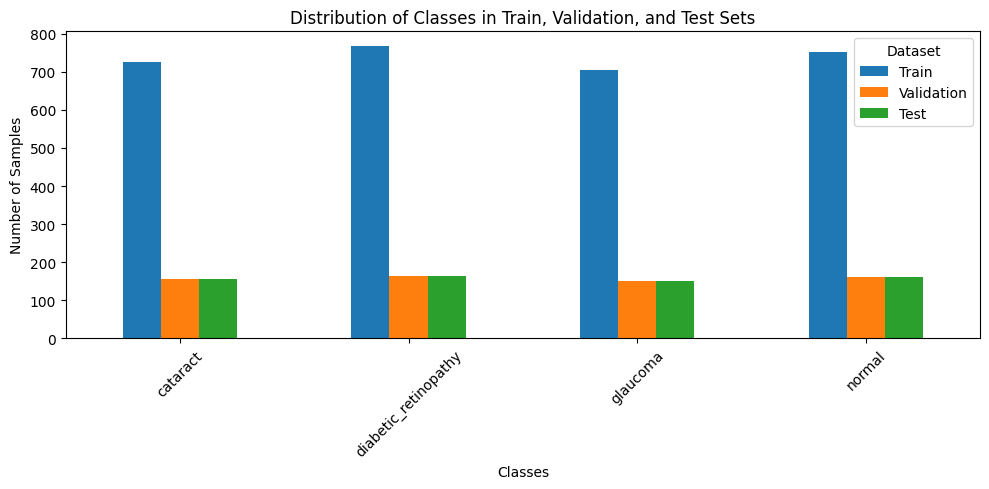

In [21]:
plt.figure(figsize=(10, 6))
df.plot(kind='bar',figsize=(10,5))
plt.title('Distribution of Classes in Train, Validation, and Test Sets')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

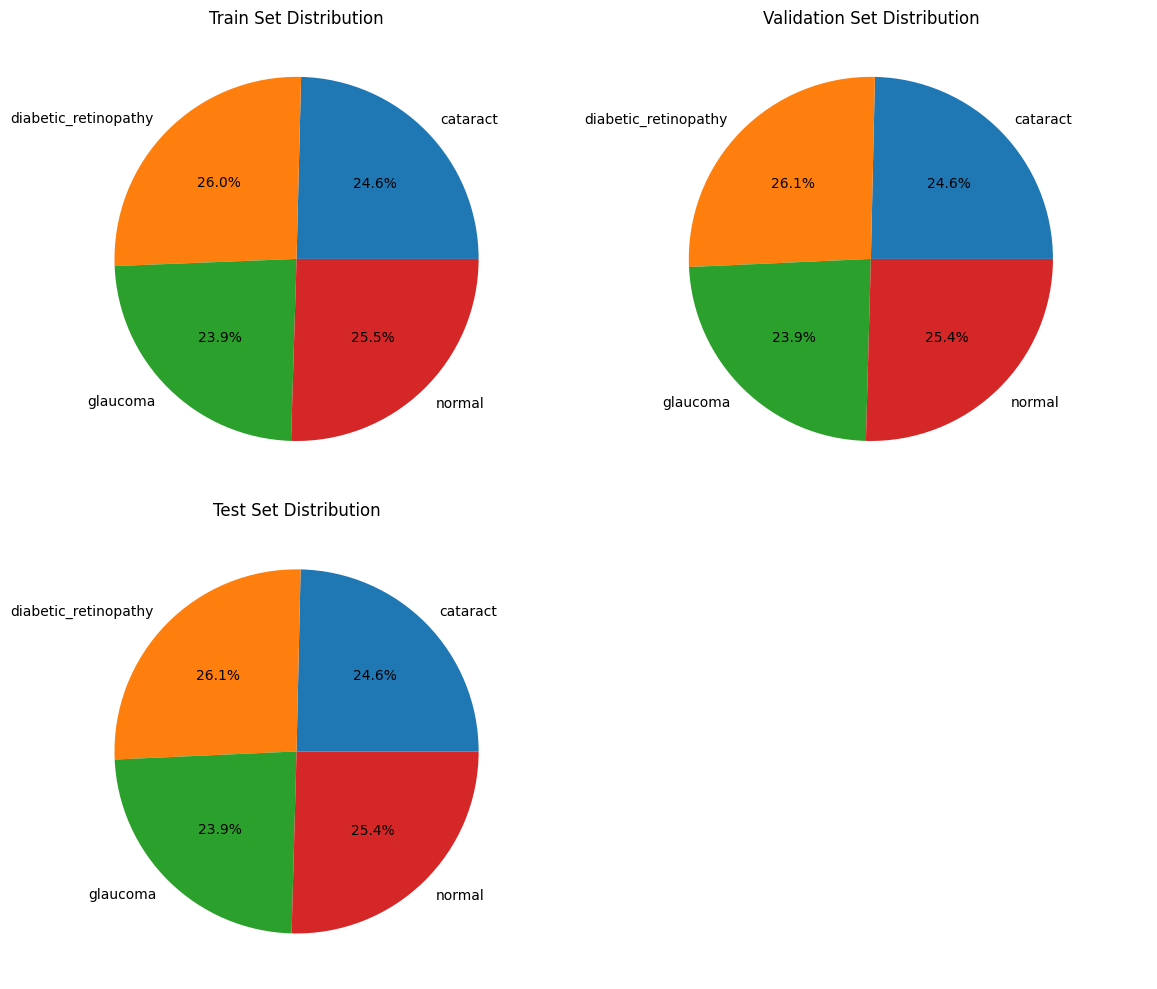

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

df.plot.pie(y='Train', autopct='%1.1f%%', title='Train Set Distribution', ax=axs[0,0], legend=False, ylabel='')
df.plot.pie(y='Validation', autopct='%1.1f%%', title='Validation Set Distribution', ax=axs[0,1], legend=False, ylabel='')
df.plot.pie(y='Test', autopct='%1.1f%%', title='Test Set Distribution', ax=axs[1,0], legend=False, ylabel='')

axs[1,1].axis('off')

plt.tight_layout()
plt.show()

#### Images In Dataset

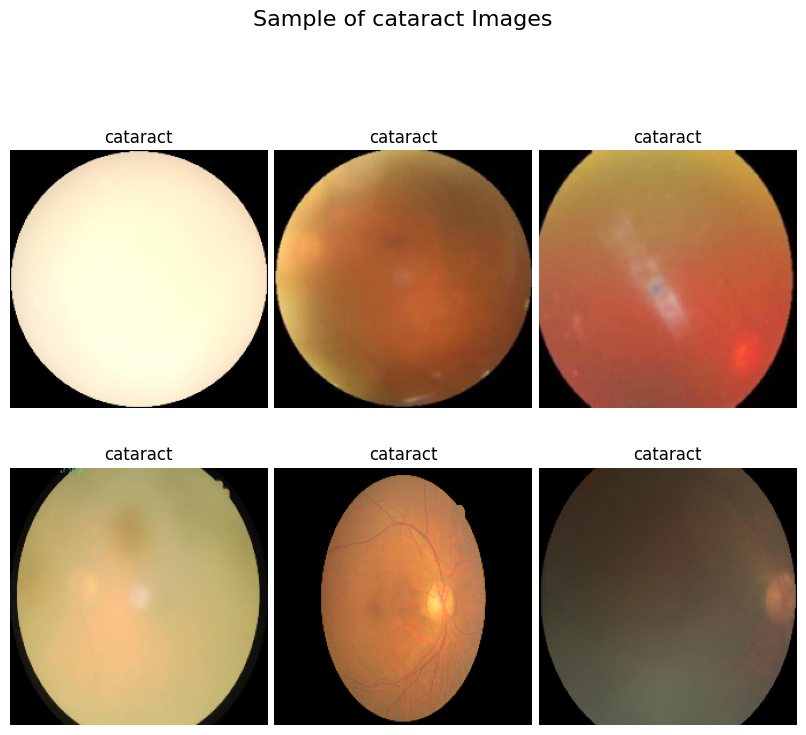

In [24]:
Class_Names = list(class_names_dict.keys())

plt.figure(figsize=(8, 8))
plt.suptitle(f"Sample of {Class_Names[0]} Images", fontsize=16)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    category_idx = np.where(Labels == 0)[0]
    idx = np.random.choice(category_idx)
    plt.imshow(Images[idx] / 255.0)
    plt.axis('off')
    plt.title(Class_Names[0])

plt.tight_layout(pad=0.5)
plt.subplots_adjust(top=0.88)
plt.show()


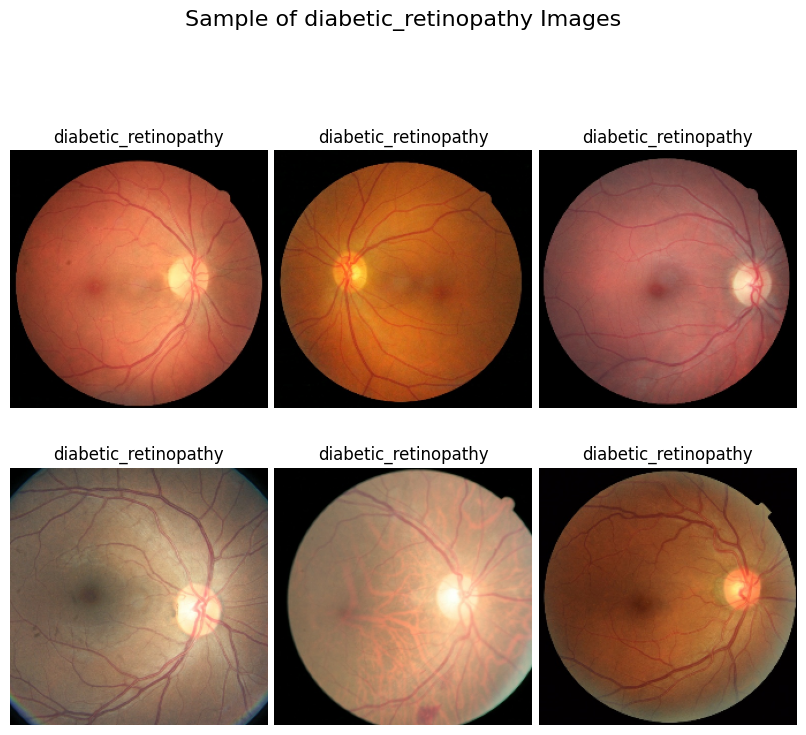

In [25]:
plt.figure(figsize=(8, 8))
plt.suptitle(f'Sample of {Class_Names[1]} Images', fontsize=16)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    Category_List = np.where(Labels == 1)[0]
    idx = np.random.choice(Category_List)
    plt.imshow(Images[idx] / 255.0)
    plt.axis('off')
    plt.title(f'{Class_Names[1]}')

plt.tight_layout(pad=0.5)
plt.subplots_adjust(top=0.88)
plt.show()

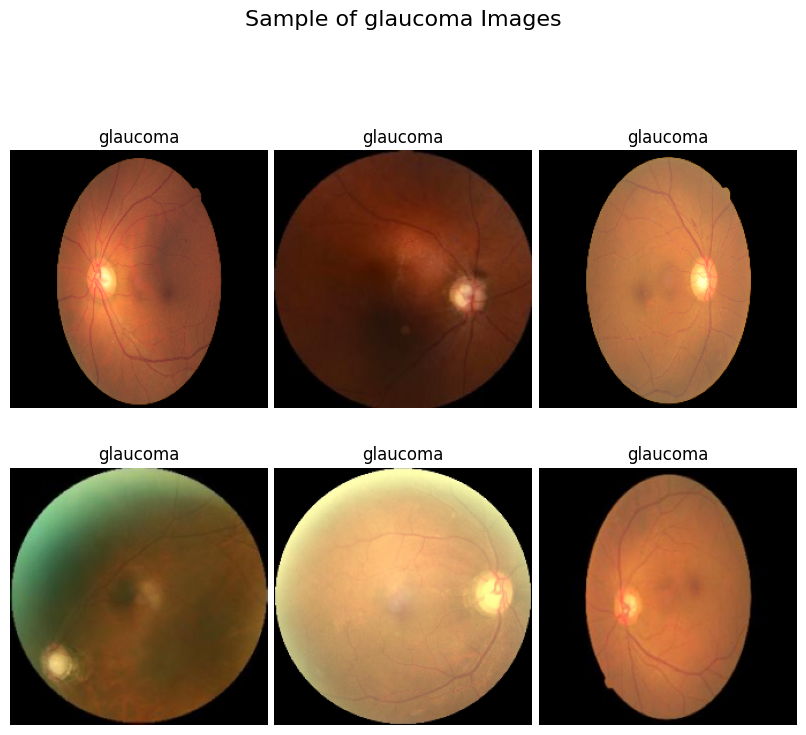

In [26]:
plt.figure(figsize=(8, 8))
plt.suptitle(f'Sample of {Class_Names[2]} Images', fontsize=16)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    Category_List = np.where(Labels == 2)[0]
    idx = np.random.choice(Category_List)
    plt.imshow(Images[idx] / 255.0)
    plt.axis('off')
    plt.title(f'{Class_Names[2]}')

plt.tight_layout(pad=0.5)
plt.subplots_adjust(top=0.88)
plt.show()

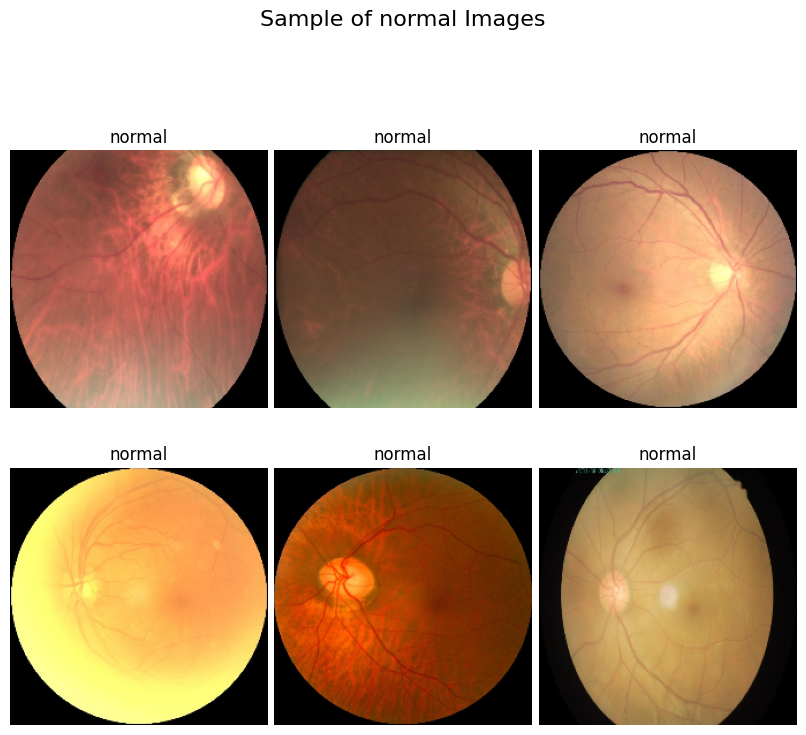

In [27]:
plt.figure(figsize=(8, 8))
plt.suptitle(f'Sample of {Class_Names[3]} Images', fontsize=16)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    Category_List = np.where(Labels == 3)[0]
    idx = np.random.choice(Category_List)
    plt.imshow(Images[idx] / 255.0)
    plt.axis('off')
    plt.title(f'{Class_Names[3]}')

plt.tight_layout(pad=0.5)
plt.subplots_adjust(top=0.88)
plt.show()

<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Model Custom CNN</h2>
</div>

#### Build Custom CNN

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range = 40,
                                   horizontal_flip = True,
                                   )

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(x=Train_Images,
    y=Train_Labels,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_generator = val_datagen.flow(x=Val_Images,
    y=Val_Labels,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_generator = test_datagen.flow(x=Test_Images,
    y=Test_Labels,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

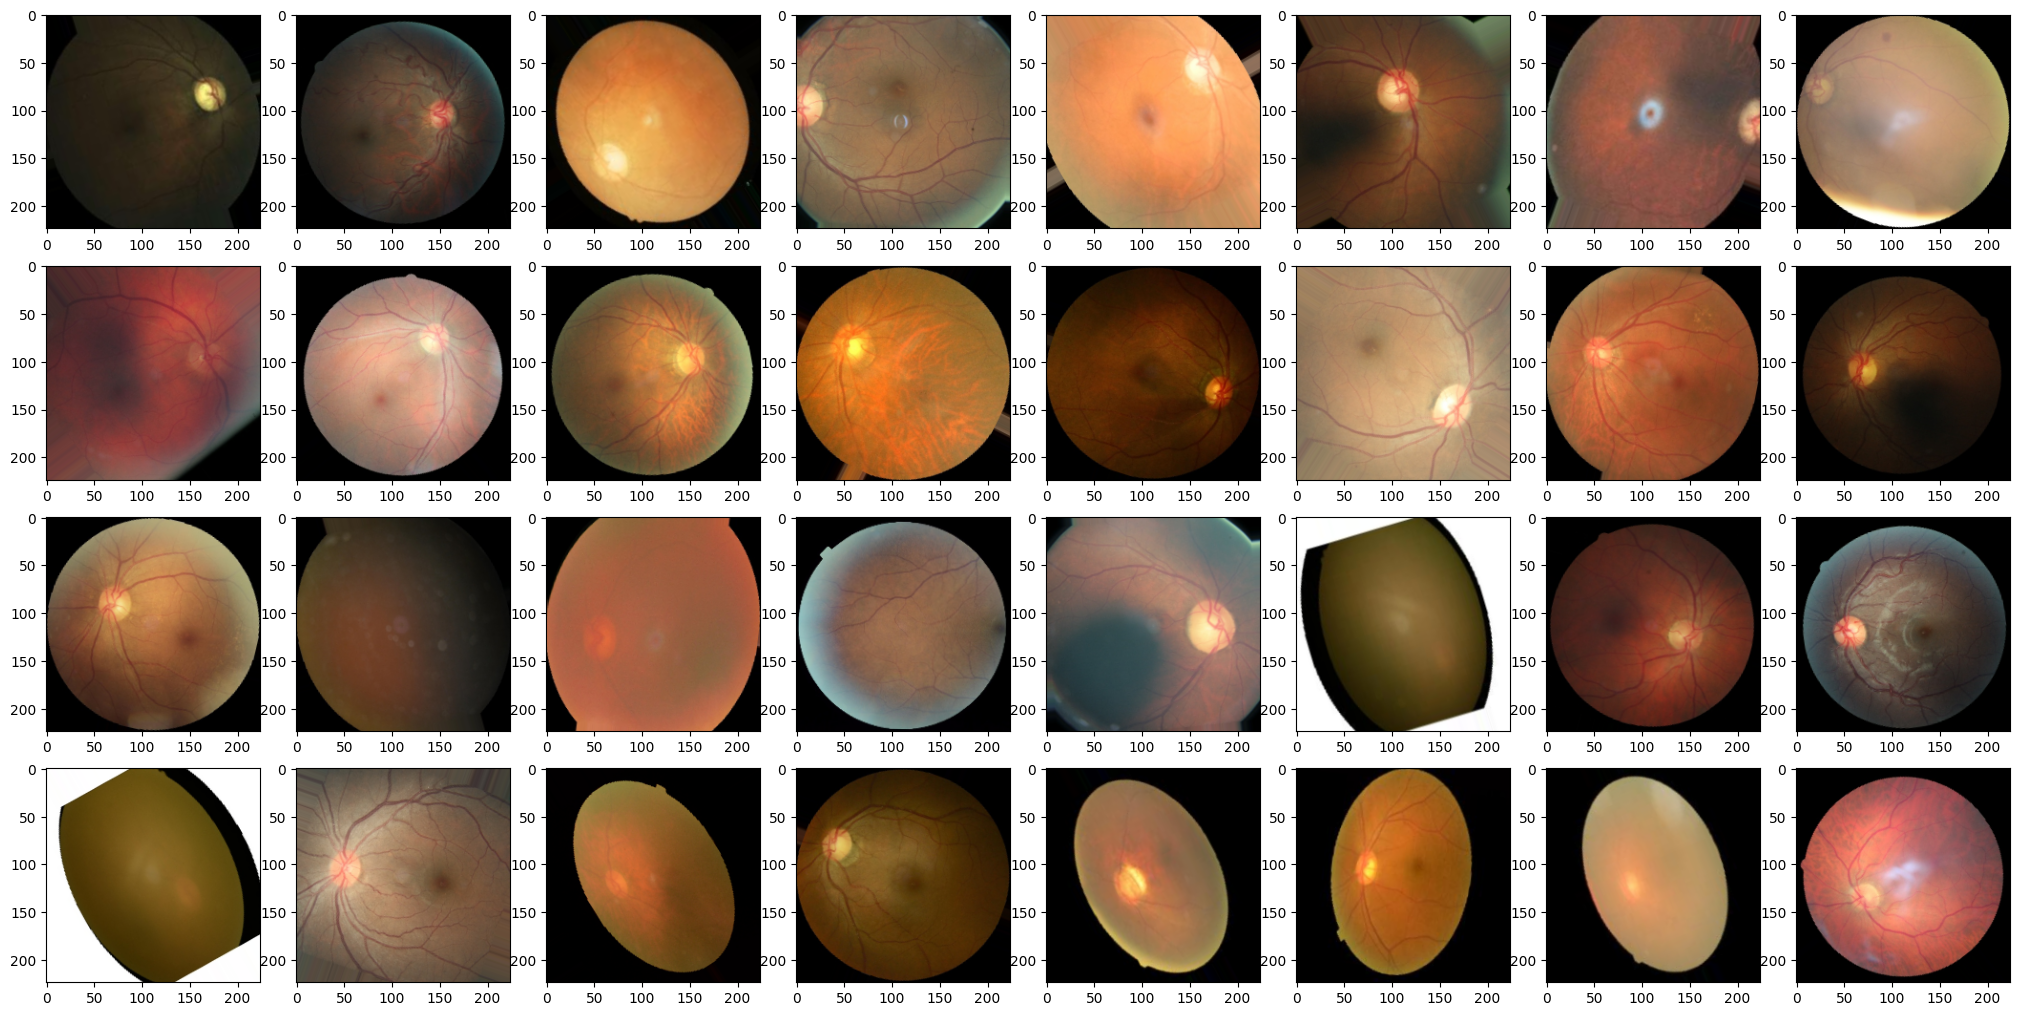

In [29]:
for x , y in train_generator:
    plt.figure(figsize=(20,20))
    for i in range(32):
        plt.subplot(8,8,i+1)
        plt.imshow(x[i])
        plt.tight_layout(pad=0 , h_pad=0 , w_pad=0)
    break

In [30]:
KerasModel = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),

    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(4, activation='softmax')
])

In [31]:
KerasModel.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [32]:
best_model_callback = keras.callbacks.ModelCheckpoint('best_model_1.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping_callback = keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                   mode = 'max',
                   patience = 10,
                   verbose = 1,
                   restore_best_weights = True)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

history = KerasModel.fit(
    train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[
        early_stopping_callback,
        best_model_callback,
        learning_rate_reduction
    ])

Epoch 1/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.3632 - loss: 1.3564

93/93 ━━━━━━━━━━━━━━━━━━━━ 84s 692ms/step - accuracy: 0.3640 - loss: 1.3543 - val_accuracy: 0.5529 - val_loss: 0.9315 - learning_rate: 0.0010
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.5673 - loss: 0.8979

93/93 ━━━━━━━━━━━━━━━━━━━━ 69s 748ms/step - accuracy: 0.5675 - loss: 0.8975 - val_accuracy: 0.6130 - val_loss: 0.8512 - learning_rate: 0.0010
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.6265 - loss: 0.7796

93/93 ━━━━━━━━━━━━━━━━━━━━ 88s 949ms/step - accuracy: 0.6266 - loss: 0.7795 - val_accuracy: 0.6335 - val_loss: 0.7740 - learning_rate: 0.0010
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.6568 - loss: 0.7269

93/93 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.6569 - loss: 0.7267 - val_accuracy: 0.6919 - val_loss: 0.6700 - learning_rate: 0.0010
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 400ms/step - accuracy: 0.6808 - loss: 0.7020 - val_accuracy: 0.6825 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step - accuracy: 0.7151 - loss: 0.6389

93/93 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.7150 - loss: 0.6389 - val_accuracy: 0.7014 - val_loss: 0.6522 - learning_rate: 0.0010
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.7172 - loss: 0.6225

93/93 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.7172 - loss: 0.6225 - val_accuracy: 0.7393 - val_loss: 0.5888 - learning_rate: 0.0010
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.7325 - loss: 0.6328

93/93 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.7328 - loss: 0.6322 - val_accuracy: 0.8231 - val_loss: 0.4471 - learning_rate: 0.0010
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 385ms/step - accuracy: 0.7735 - loss: 0.5319 - val_accuracy: 0.8104 - val_loss: 0.4484 - learning_rate: 0.0010
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8125 - loss: 0.4674

93/93 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8125 - loss: 0.4675 - val_accuracy: 0.8404 - val_loss: 0.4052 - learning_rate: 0.0010
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 65s 388ms/step - accuracy: 0.8077 - loss: 0.4811 - val_accuracy: 0.8294 - val_loss: 0.4414 - learning_rate: 0.0010
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.8415 - loss: 0.4044

93/93 ━━━━━━━━━━━━━━━━━━━━ 91s 989ms/step - accuracy: 0.8415 - loss: 0.4045 - val_accuracy: 0.8167 - val_loss: 0.3875 - learning_rate: 0.0010
Epoch 13/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8320 - loss: 0.4129

93/93 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.8321 - loss: 0.4127 - val_accuracy: 0.8547 - val_loss: 0.3408 - learning_rate: 0.0010
Epoch 14/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 388ms/step - accuracy: 0.8533 - loss: 0.3790 - val_accuracy: 0.8452 - val_loss: 0.3792 - learning_rate: 0.0010
Epoch 15/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.8510 - loss: 0.3878 - val_accuracy: 0.8499 - val_loss: 0.3587 - learning_rate: 0.0010
Epoch 16/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 392ms/step - accuracy: 0.8660 - loss: 0.3397 - val_accuracy: 0.8705 - val_loss: 0.3499 - learning_rate: 0.0010
Epoch 17/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.8539 - loss: 0.3608

93/93 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8540 - loss: 0.3607 - val_accuracy: 0.8799 - val_loss: 0.3264 - learning_rate: 0.0010
Epoch 18/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 392ms/step - accuracy: 0.8573 - loss: 0.3425 - val_accuracy: 0.8705 - val_loss: 0.3292 - learning_rate: 0.0010
Epoch 19/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 35s 381ms/step - accuracy: 0.8451 - loss: 0.3839 - val_accuracy: 0.8610 - val_loss: 0.3382 - learning_rate: 0.0010
Epoch 20/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8726 - loss: 0.3228

93/93 ━━━━━━━━━━━━━━━━━━━━ 123s 1s/step - accuracy: 0.8726 - loss: 0.3229 - val_accuracy: 0.8799 - val_loss: 0.2999 - learning_rate: 0.0010
Epoch 21/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 394ms/step - accuracy: 0.8811 - loss: 0.3013 - val_accuracy: 0.8847 - val_loss: 0.3078 - learning_rate: 0.0010
Epoch 22/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 387ms/step - accuracy: 0.8642 - loss: 0.3245 - val_accuracy: 0.8784 - val_loss: 0.3434 - learning_rate: 0.0010
Epoch 23/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 390ms/step - accuracy: 0.8636 - loss: 0.3273 - val_accuracy: 0.8720 - val_loss: 0.3251 - learning_rate: 0.0010
Epoch 24/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 37s 393ms/step - accuracy: 0.8787 - loss: 0.3111 - val_accuracy: 0.8578 - val_loss: 0.3531 - learning_rate: 0.0010
Epoch 25/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 381ms/step - accuracy: 0.8636 - loss: 0.3187 - val_accuracy: 0.8657 - val_loss: 0.3452 - learning_rate: 0.0010
Epoch 26/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 42s 396ms/step - accuracy: 0.8657 - loss: 0.3

93/93 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.8854 - loss: 0.2732 - val_accuracy: 0.8831 - val_loss: 0.2888 - learning_rate: 0.0010
Epoch 30/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 389ms/step - accuracy: 0.8875 - loss: 0.2957 - val_accuracy: 0.8720 - val_loss: 0.3054 - learning_rate: 0.0010
Epoch 31/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8961 - loss: 0.2498

93/93 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8961 - loss: 0.2500 - val_accuracy: 0.8673 - val_loss: 0.2873 - learning_rate: 0.0010
Epoch 31: early stopping
Restoring model weights from the end of the best epoch: 21.


#### Summary of KerasModel


In [33]:
print(KerasModel.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   102,760,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 310,035,566 (1.15 GB)

 Trainable params: 103,345,188 (394.23 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 206,690,378 (788.46 MB)

None


<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Evaluate Custom CNN</h2>
</div>

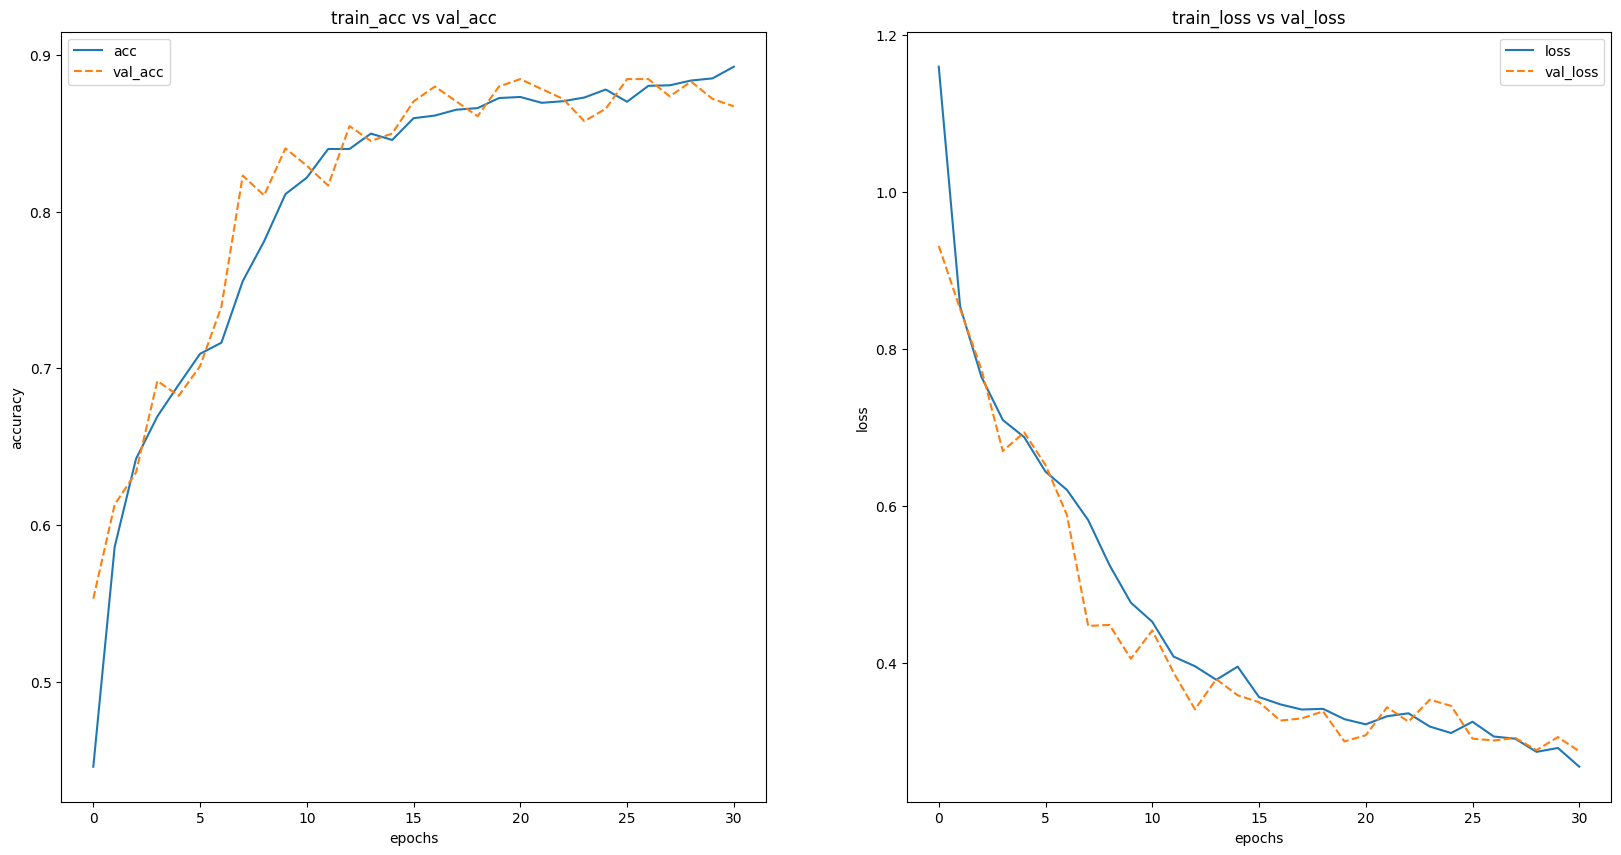

In [34]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'],'-', label = "acc")
    plt.plot(history.history['val_accuracy'], '--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(122)
    plt.plot(history.history['loss'],'-', label = "loss")
    plt.plot(history.history['val_loss'], '--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
plot_accuracy_loss(history)

In [35]:
model = keras.models.load_model('best_model_1.h5')
predictions = model.predict(test_generator)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step


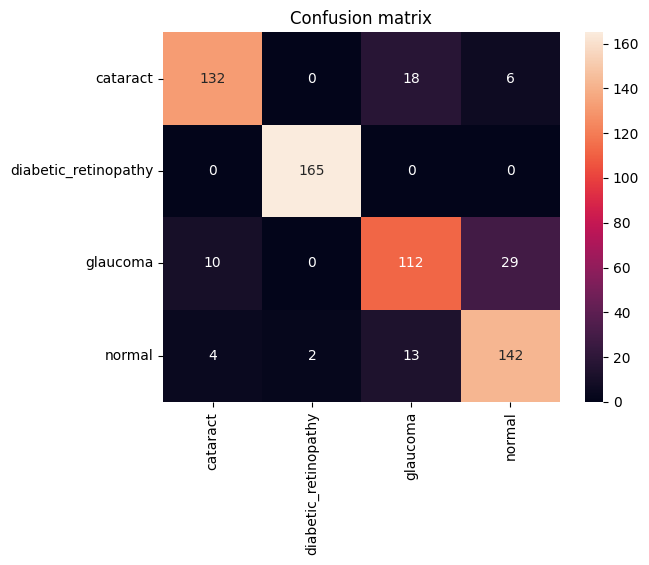

In [36]:
CM = confusion_matrix(Test_Labels, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels = Class_Names,
           yticklabels = Class_Names,
           ax = ax,
           fmt='d')
ax.set_title('Confusion matrix')
plt.show()

In [37]:
print(classification_report(Test_Labels, pred_labels,target_names = Class_Names))

                      precision    recall  f1-score   support

            cataract       0.90      0.85      0.87       156
diabetic_retinopathy       0.99      1.00      0.99       165
            glaucoma       0.78      0.74      0.76       151
              normal       0.80      0.88      0.84       161

            accuracy                           0.87       633
           macro avg       0.87      0.87      0.87       633
        weighted avg       0.87      0.87      0.87       633



<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Predicting with Custom CNN</h2>
</div>

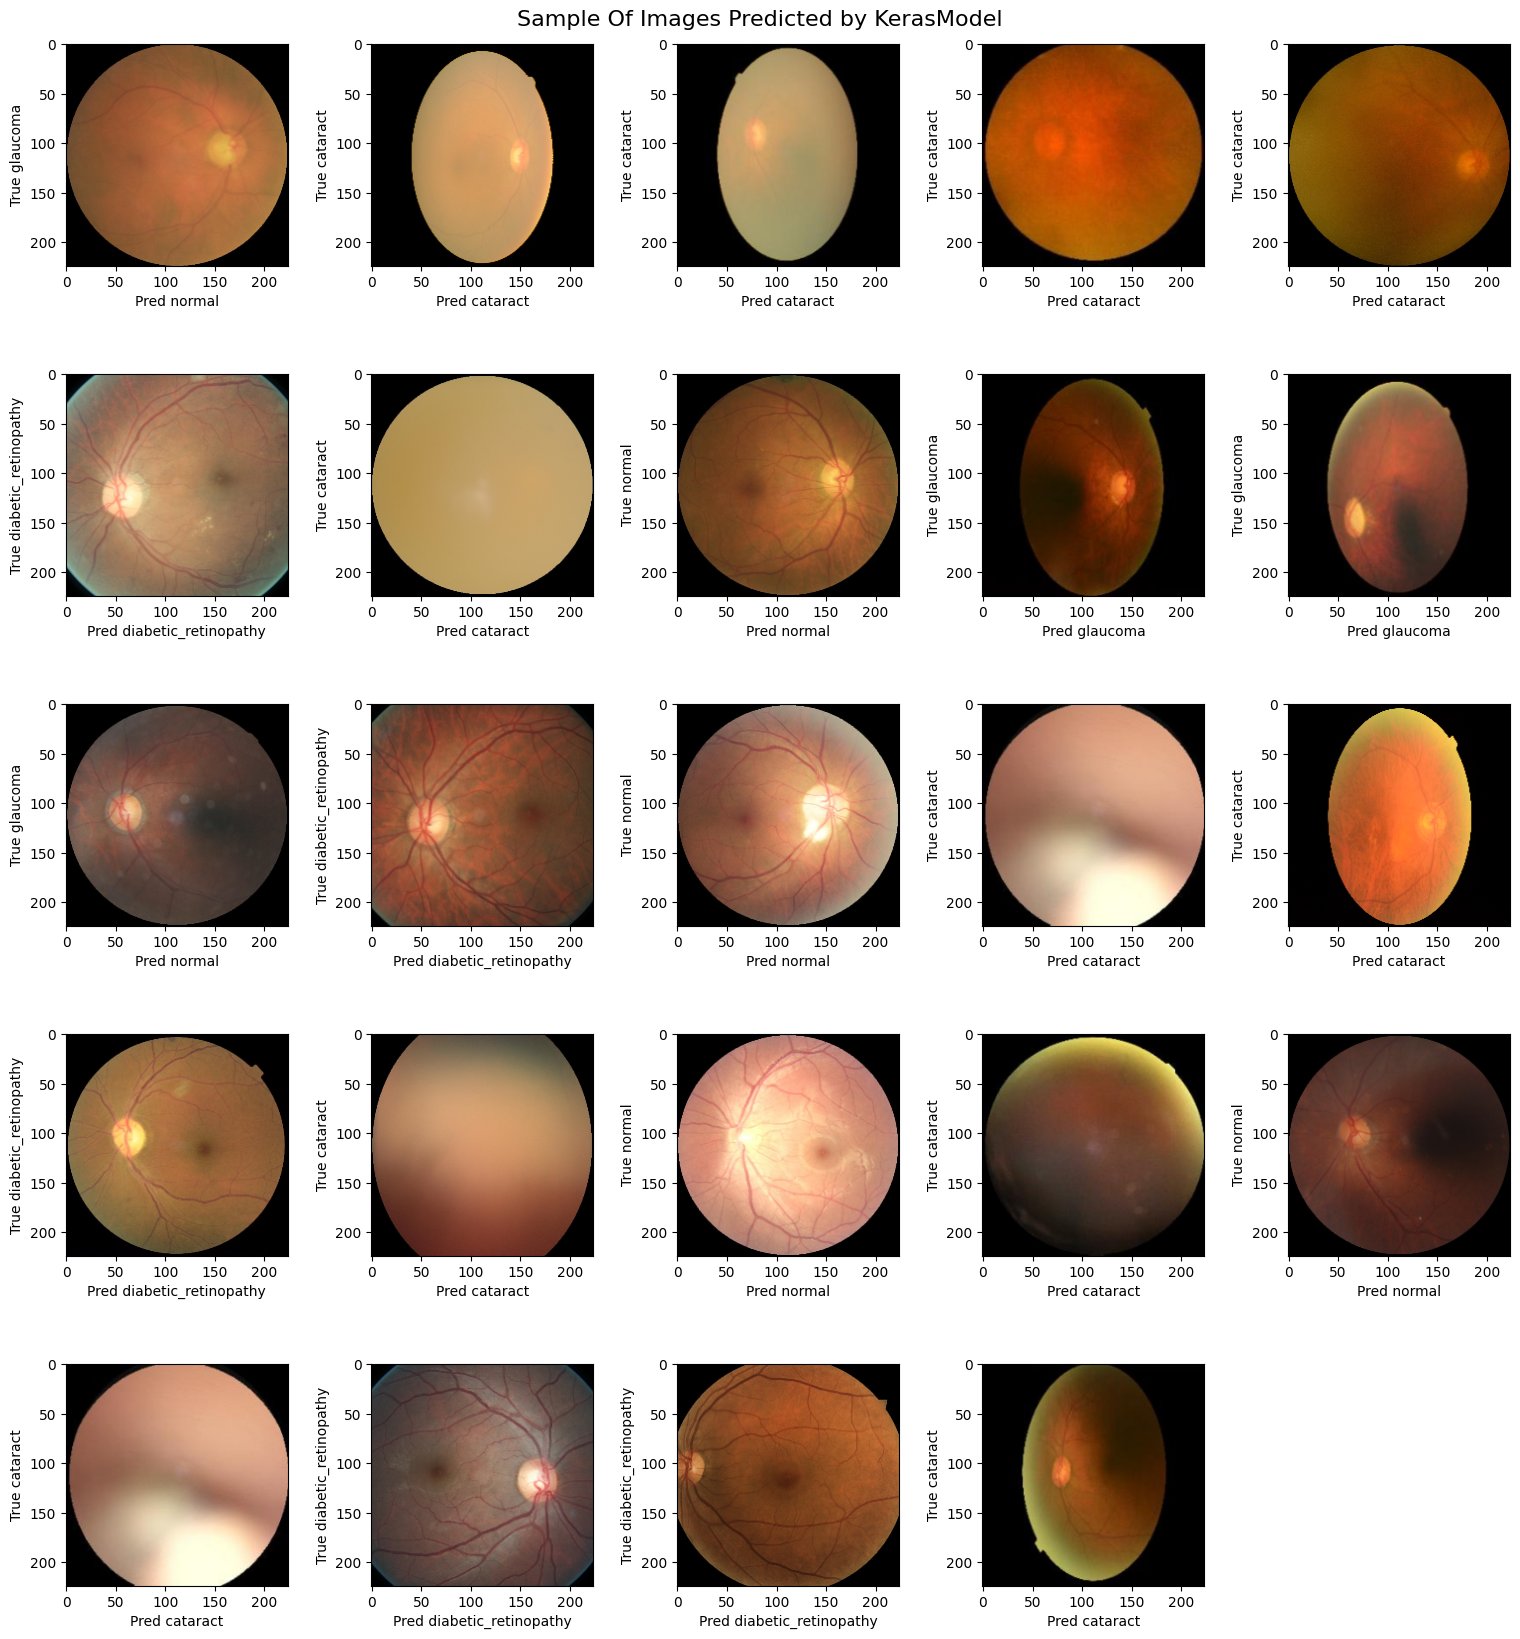

In [38]:
plt.figure(figsize=(15,20))
plt.suptitle(f"Sample Of Images Predicted by KerasModel" , fontsize=16)

for i in range(24):
    plt.subplot(6,5,i+1)
    idx = np.random.choice(np.arange(len(pred_labels)))
    plt.imshow(Test_Images[idx] / 255.0)
    plt.xlabel(f'Pred {Class_Names[pred_labels[idx]]}')
    plt.ylabel(f'True {Class_Names[Test_Labels[idx]]}')
    plt.tight_layout(pad=0 , h_pad=0 , w_pad=2)

<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Pretrained Modeling</h2>
</div>

#### Transfer Learning

In [39]:
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range = 40,
                                   horizontal_flip = True,
                                   )

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,)

train_generator = train_datagen.flow(x=Train_Images,
    y=Train_Labels,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

val_generator = val_datagen.flow(x=Val_Images,
    y=Val_Labels,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_generator = test_datagen.flow(x=Test_Images,
    y=Test_Labels,
    batch_size=BATCH_SIZE,
    shuffle=False,
)

In [40]:
from tensorflow.keras.applications import EfficientNetB7

# Load pre-trained VGG19 model (without top layers)
base_model = EfficientNetB7(weights='imagenet',
                   include_top=False,
                   input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], CHANNELS))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build custom top layers
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
outputs = keras.layers.Dense(4, activation='softmax')(x)

# Define the final model
model_EfficientNetB7 = keras.Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model_EfficientNetB7.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

best_model_callback = keras.callbacks.ModelCheckpoint('model_EfficientNetB7.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping_callback = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Train the model
history_model_EfficientNetB7 = model_EfficientNetB7.fit(
   train_generator,
    epochs=200,
    validation_data=val_generator,
    callbacks=[
        early_stopping_callback,
        best_model_callback,
    ])

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Epoch 1/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 926ms/step - accuracy: 0.6430 - loss: 0.8891

93/93 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step - accuracy: 0.6438 - loss: 0.8870 - val_accuracy: 0.7836 - val_loss: 0.5990
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.8126 - loss: 0.4712

93/93 ━━━━━━━━━━━━━━━━━━━━ 75s 808ms/step - accuracy: 0.8127 - loss: 0.4711 - val_accuracy: 0.7852 - val_loss: 0.5512
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.8359 - loss: 0.4248

93/93 ━━━━━━━━━━━━━━━━━━━━ 98s 986ms/step - accuracy: 0.8359 - loss: 0.4247 - val_accuracy: 0.8183 - val_loss: 0.5010
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.8400 - loss: 0.3980

93/93 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8400 - loss: 0.3981 - val_accuracy: 0.8357 - val_loss: 0.4539
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 472ms/step - accuracy: 0.8504 - loss: 0.3774 - val_accuracy: 0.8073 - val_loss: 0.4972
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 463ms/step - accuracy: 0.8643 - loss: 0.3540 - val_accuracy: 0.7757 - val_loss: 0.5442
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8715 - loss: 0.3204

93/93 ━━━━━━━━━━━━━━━━━━━━ 85s 918ms/step - accuracy: 0.8716 - loss: 0.3204 - val_accuracy: 0.8468 - val_loss: 0.4075
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 470ms/step - accuracy: 0.8699 - loss: 0.3254 - val_accuracy: 0.8120 - val_loss: 0.4546
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.8867 - loss: 0.2826

93/93 ━━━━━━━━━━━━━━━━━━━━ 81s 873ms/step - accuracy: 0.8866 - loss: 0.2828 - val_accuracy: 0.8404 - val_loss: 0.4046
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 461ms/step - accuracy: 0.8932 - loss: 0.2819 - val_accuracy: 0.8357 - val_loss: 0.4410
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 459ms/step - accuracy: 0.8756 - loss: 0.2994 - val_accuracy: 0.8420 - val_loss: 0.4301
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 459ms/step - accuracy: 0.8909 - loss: 0.2680 - val_accuracy: 0.7867 - val_loss: 0.5596
Epoch 13/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.9080 - loss: 0.2506

93/93 ━━━━━━━━━━━━━━━━━━━━ 79s 848ms/step - accuracy: 0.9080 - loss: 0.2506 - val_accuracy: 0.8673 - val_loss: 0.3556
Epoch 14/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 466ms/step - accuracy: 0.8936 - loss: 0.2566 - val_accuracy: 0.8167 - val_loss: 0.4651
Epoch 15/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - accuracy: 0.8947 - loss: 0.2713

93/93 ━━━━━━━━━━━━━━━━━━━━ 82s 887ms/step - accuracy: 0.8947 - loss: 0.2712 - val_accuracy: 0.8847 - val_loss: 0.3432
Epoch 16/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 45s 477ms/step - accuracy: 0.9069 - loss: 0.2386 - val_accuracy: 0.8373 - val_loss: 0.4133
Epoch 17/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 467ms/step - accuracy: 0.9145 - loss: 0.2227 - val_accuracy: 0.8547 - val_loss: 0.3570
Epoch 18/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 466ms/step - accuracy: 0.9156 - loss: 0.2236 - val_accuracy: 0.8341 - val_loss: 0.3880
Epoch 19/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 463ms/step - accuracy: 0.9251 - loss: 0.2056 - val_accuracy: 0.8515 - val_loss: 0.3640
Epoch 20/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 464ms/step - accuracy: 0.9097 - loss: 0.2182 - val_accuracy: 0.8325 - val_loss: 0.4585
Epoch 21/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 466ms/step - accuracy: 0.9104 - loss: 0.2134 - val_accuracy: 0.8373 - val_loss: 0.3987
Epoch 22/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 43s 464ms/step - accuracy: 0.9265 - loss: 0.2050 - val_a

<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Evaluate EfficientNetB7</h2>
</div>

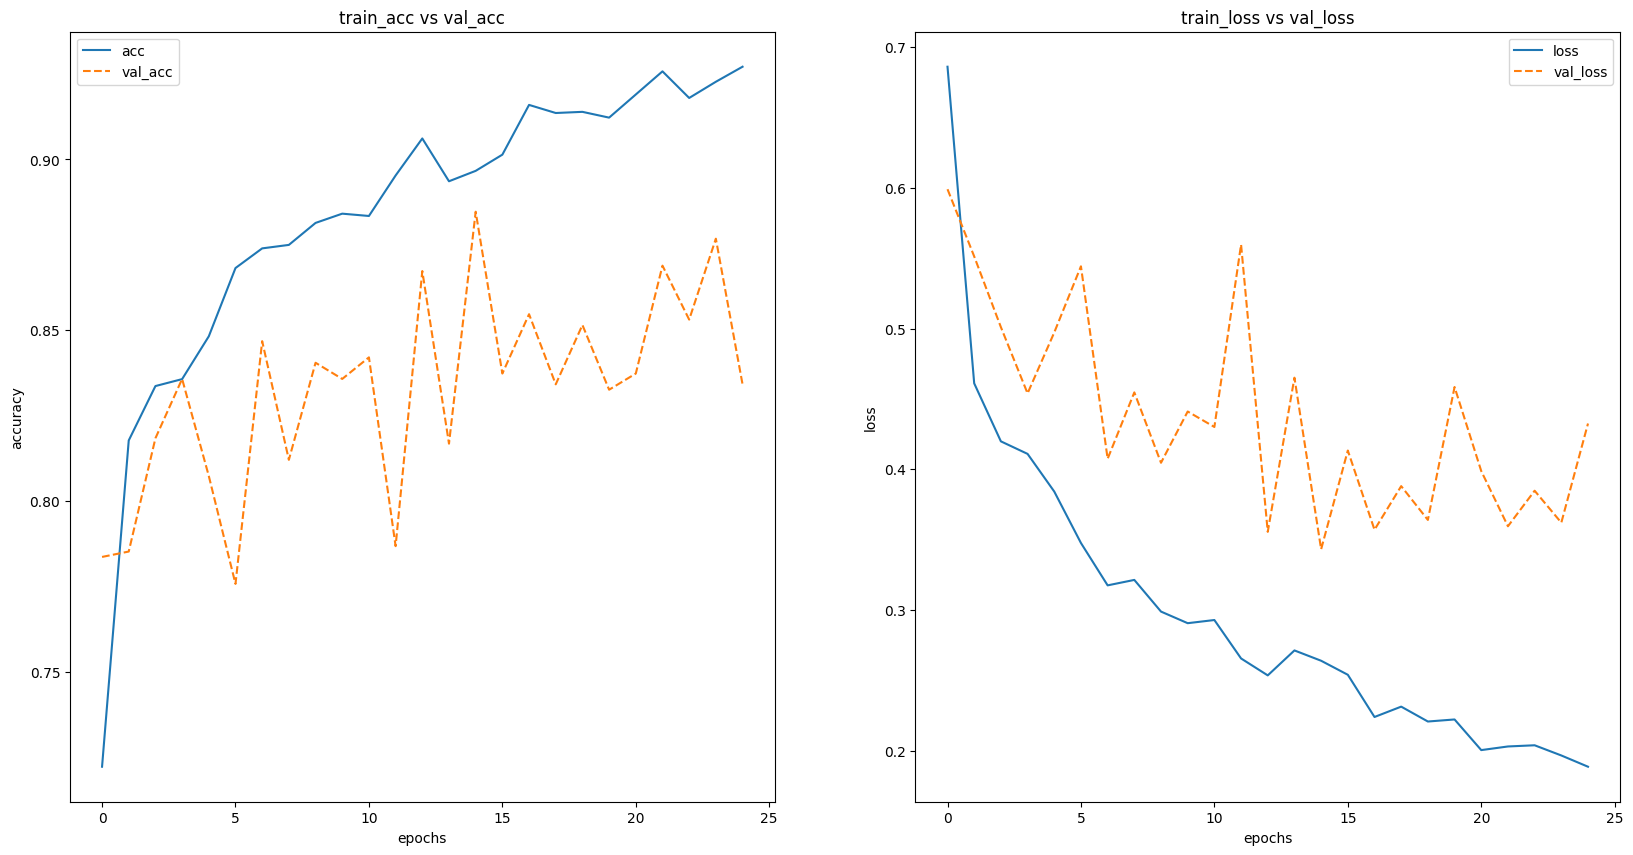

In [41]:
def plot_accuracy_loss(history):
    """
        Plot the accuracy and the loss during the training of the nn.
    """
    fig = plt.figure(figsize=(20,10))

    # Plot accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'],'-', label = "acc")
    plt.plot(history.history['val_accuracy'], '--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    # Plot loss function
    plt.subplot(122)
    plt.plot(history.history['loss'],'-', label = "loss")
    plt.plot(history.history['val_loss'], '--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()
plot_accuracy_loss(history_model_EfficientNetB7)

In [42]:
model = keras.models.load_model('model_EfficientNetB7.h5')
predictions = model.predict(test_generator)     # Vector of probabilities
pred_labels = np.argmax(predictions, axis = 1) # We take the highest probability

20/20 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step


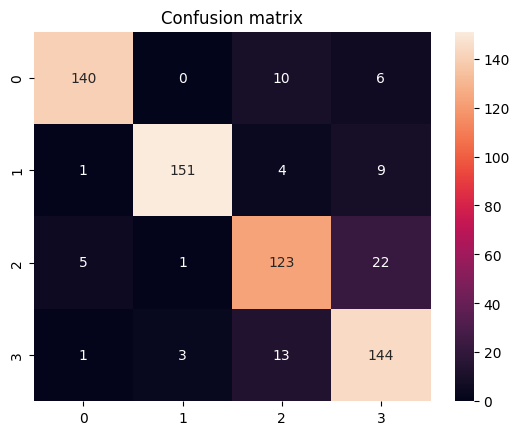

In [48]:
##%%
CM = confusion_matrix(Test_Labels, pred_labels)
ax = plt.axes()
sns.heatmap(CM, annot=True,
           annot_kws={"size": 10},
           xticklabels = Class_Names_Dict.keys(),
           yticklabels = Class_Names_Dict.keys(),
           ax = ax,
           fmt='d')
ax.set_title('Confusion matrix')
plt.show()

In [50]:
print(
    classification_report(
        Test_Labels,
        pred_labels,
        target_names=[Class_Names_Dict[i] for i in sorted(Class_Names_Dict)]
    )
)


                      precision    recall  f1-score   support

            cataract       0.95      0.90      0.92       156
diabetic_retinopathy       0.97      0.92      0.94       165
            glaucoma       0.82      0.81      0.82       151
              normal       0.80      0.89      0.84       161

            accuracy                           0.88       633
           macro avg       0.89      0.88      0.88       633
        weighted avg       0.89      0.88      0.88       633



<div style="background-color:black;
            color:white;
            transform:skew(-20deg);
            padding:30px;
            font-family:Verdana;
            letter-spacing:1px;
            margin:auto;
            width:fit-content;">
    <h2 style="transform:skew(20deg); margin:0;">Predicting with EfficientNetB7</h2>
</div>

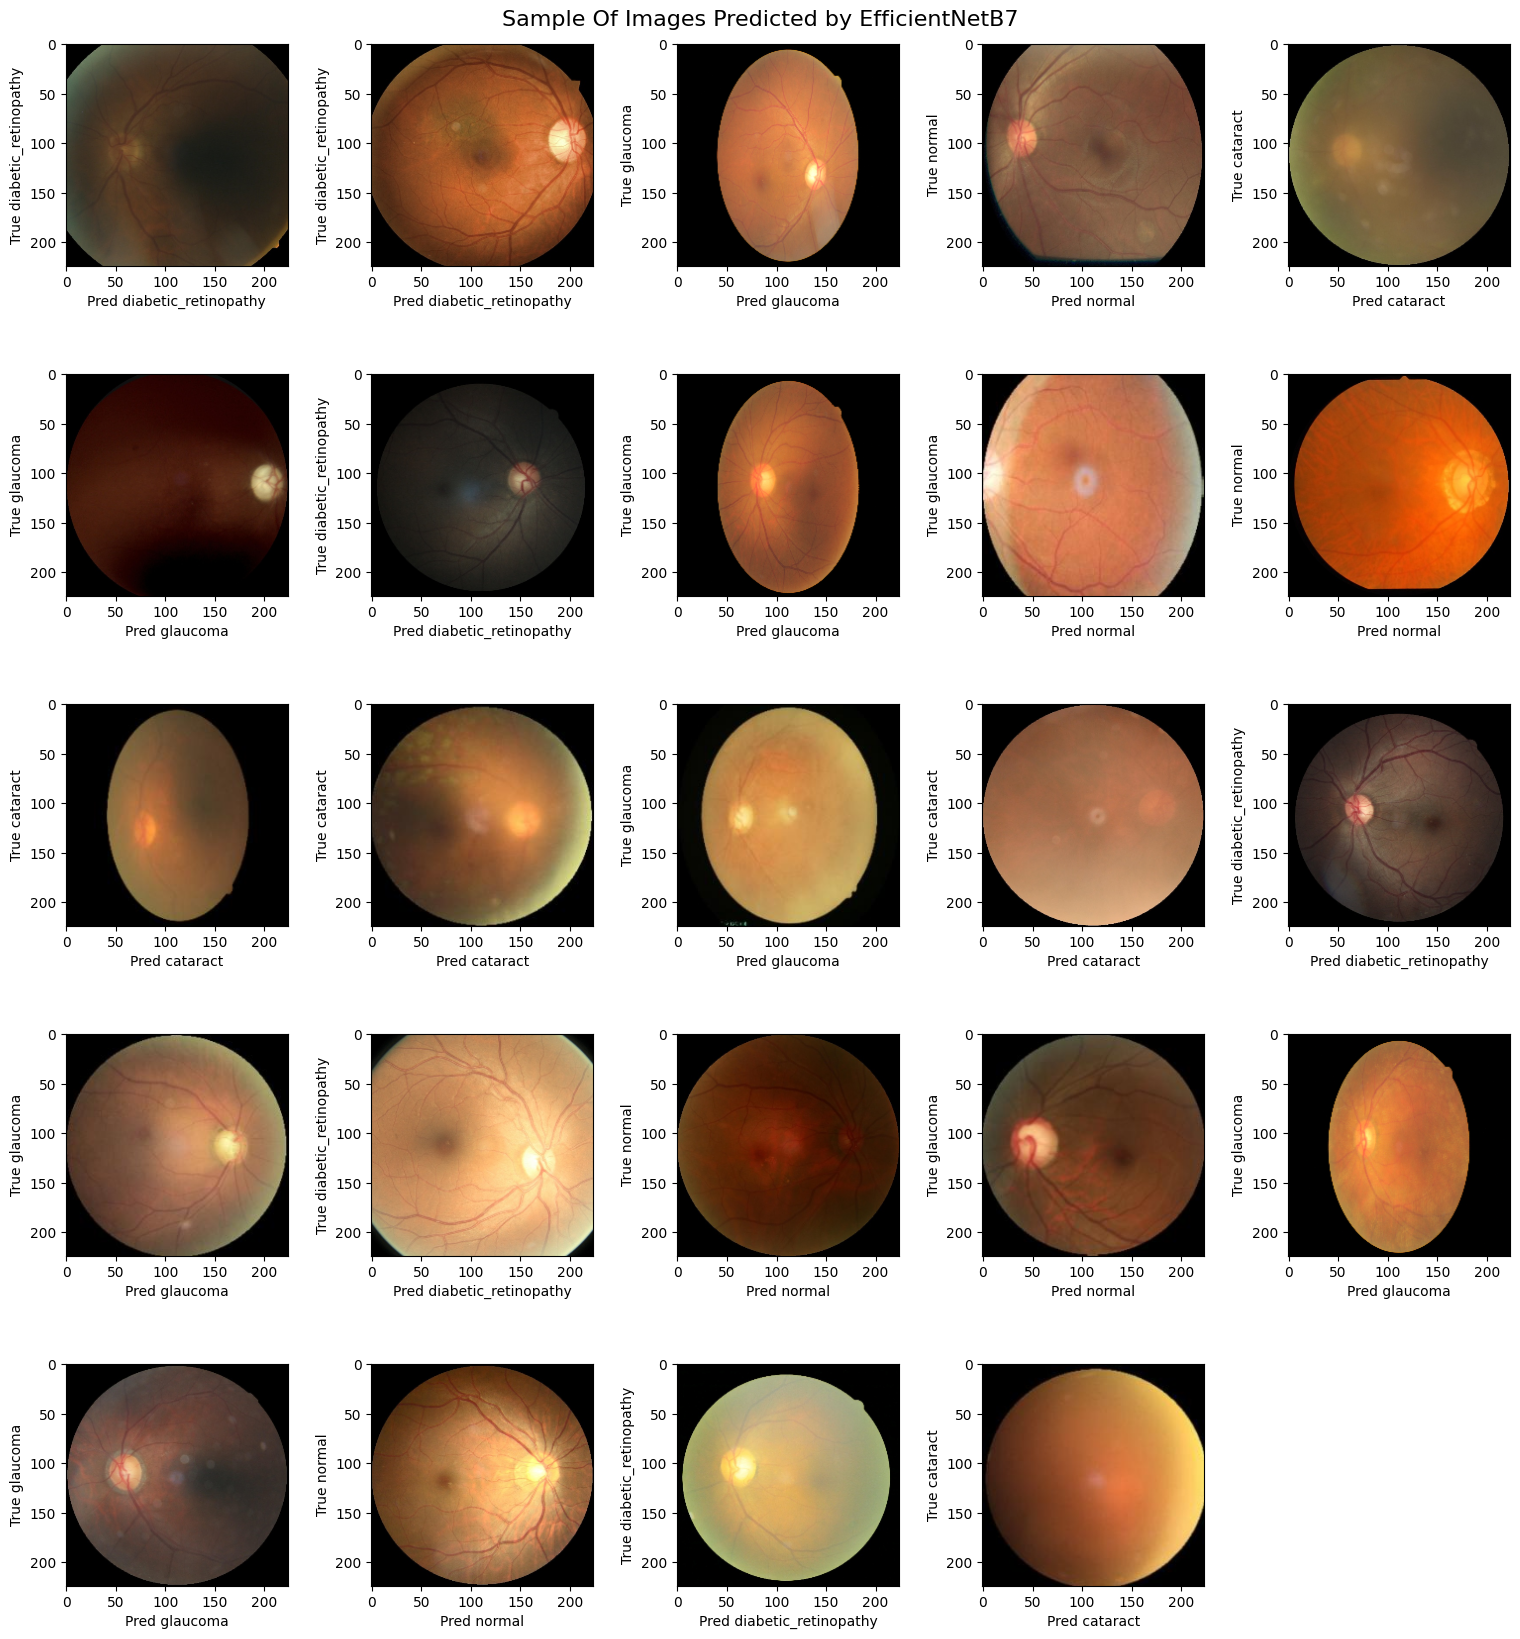

In [51]:
plt.figure(figsize=(15,20))
plt.suptitle(f"Sample Of Images Predicted by EfficientNetB7" , fontsize=16)

for i in range(24):
    plt.subplot(6,5,i+1)
    idx = np.random.choice(np.arange(len(pred_labels)))
    plt.imshow(Test_Images[idx] / 255.0)
    plt.xlabel(f'Pred {Class_Names[pred_labels[idx]]}')
    plt.ylabel(f'True {Class_Names[Test_Labels[idx]]}')
    plt.tight_layout(pad=0 , h_pad=0 , w_pad=2)

In [52]:
from google.colab import files
files.download("model_EfficientNetB7.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>